# Notebook for calculating Bispectrum
This notebook illustrates how to calculate the vanilla halo model bispectrum with this code

## Preparations

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb
import pyccl as ccl

# Project imports
#import pyhalomodel as halo
#import pyhalomodel as halo

import sys
sys.path.insert(1, '../pyhalomodel/')
from hmcode import BiHMCode_bispectrum


In [2]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 2e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # [eV]
sigma_8_set = True # If True uses the following value
sigma_8  = 0.8

# Wavenumber range [h/Mpc]
kmin, kmax = 1e-3, 10.
nk = 51
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0.
a=1/(1+z)

# Halo mass range [Msun/h] over which to integrate
Mmin, Mmax = 1e9, 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# CAMB
zmax_CAMB = 2.
kmax_CAMB = 200.

## Calculate linear powerspectrum (with CAMB)

In [3]:
# # Sets cosmological parameters in camb to calculate the linear power spectrum
# pars = camb.CAMBparams()
# wb = Omega_b*h**2
# wc = Omega_c*h**2

# # This function sets standard and helium set using BBN consistency
# pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
# pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
# pars.InitPower.set_params(As=As, ns=ns, r=0.)
# pars.set_matter_power(redshifts=[z], kmax=kmax_CAMB) # Setup the linear matter power spectrum

# # Scale 'As' to be correct for the desired 'sigma_8' value if necessary
# if sigma_8_set:
#     camb_results = camb.get_results(pars)
#     sigma_8_init = (camb_results.get_sigma8()[[z].index(0.)]).item()
#     print('Initial sigma_8:', sigma_8_init)
#     scaling = (sigma_8/sigma_8_init)**2
#     As *= scaling
#     pars.InitPower.set_params(As=As, ns=ns, r=0.)

# # Now get the linear power spectrum
# Pk_lin = camb.get_matter_power_interpolator(pars, 
#                                             nonlinear=False, 
#                                             hubble_units=True, 
#                                             k_hunit=True, 
#                                             kmax=kmax_CAMB,
#                                             var1=camb.model.Transfer_tot,
#                                             var2=camb.model.Transfer_tot, 
#                                             zmax=zmax_CAMB,
#                                            )
# Omega_m  = pars.omegam # Also extract the matter density
# Pks_lin = Pk_lin.P(z, ks) # Single out the linear P(k) interpolator and evaluate linear power
# camb_results = camb.get_results(pars)
# sigma_8 = (camb_results.get_sigma8()[[z].index(0.)]).item()
# if sigma_8_set: print('Final sigma_8:', sigma_8)

In [4]:
# # dewiggling

# cosmoNoWiggle=ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns, sigma8=sigma_8, transfer_function="eisenstein_hu_nowiggles")
# pk_lin_noWiggle=ccl.linear_matter_power(cosmoNoWiggle, ks, a)

# cosmoWiggle=ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns, sigma8=sigma_8, transfer_function="eisenstein_hu")
# pk_lin_Wiggle=ccl.linear_matter_power(cosmoWiggle, ks, a)

# sigma_v=np.trapz(Pks_lin, ks)/6/np.pi**2
# #sigma_v=2
# Pwig=pk_lin_Wiggle-pk_lin_noWiggle
# #Psmt=pk_lin_Wiggle-Pwig
# Psmt=Pks_lin-Pwig

# f=np.exp(-ks*ks*sigma_v)
# Pdwg=(Psmt+(1-f)*Pwig)


## Parameters and ingredients

In [5]:
ingredients={'hmf': 'Sheth & Tormen (1999)', 
             'concentration': 'Duffy et al. (2008)',
             'halo definition': 'Mvir', 
             'profile': 'NFW'}

freeParsVanilla={   'eta':0, 
                    'B':4, 
                    'alpha1':1, 
                    'alpha2':1,
                    'kstar':0,
                    'f':0,
                    'kd':0,
                    'nd':1}

freeParsHMCode2020={'eta':0.139, 
                    'B':5.2, 
                    'alpha1':1, 
                    'alpha2':1,
                    'kstar':0.07,
                    'f':0.019,
                    'kd':0.073,
                    'nd':2.85}

In [6]:
Cosmology=ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns, sigma8=sigma_8)

In [7]:
BispecVanilla, Bi_1hVanilla, Bi_2hVanilla, Bi_3hVanilla=BiHMCode_bispectrum(ks, Ms, Cosmology, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsVanilla,
                                                                           onlyEquilateral=False, dewiggle=False)

In [8]:
BispecHMCode2020, Bi_1hHMCode2020, Bi_2hHMCode2020, Bi_3hHMCode2020=BiHMCode_bispectrum(ks, Ms, Cosmology, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsHMCode2020,
                                                                           onlyEquilateral=False, dewiggle=False)

In [9]:
BispecVanilla_fast, Bi_1hVanilla_fast, Bi_2hVanilla_fast, Bi_3hVanilla_fast=BiHMCode_bispectrum(ks, Ms, Cosmology, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsVanilla,
                                                                           fastCalc=True,
                                                                           onlyEquilateral=False, dewiggle=False)

In [10]:
BispecHMCode2020_fast, Bi_1hHMCode2020_fast, Bi_2hHMCode2020_fast, Bi_3hHMCode2020_fast=BiHMCode_bispectrum(ks, Ms, Cosmology, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsHMCode2020,
                                                                           fastCalc=True,
                                                                           onlyEquilateral=False, dewiggle=False)

In [11]:
BispecHMCode2020_fast_dwg, Bi_1hHMCode2020_fast_dwg, Bi_2hHMCode2020_fast_dwg, Bi_3hHMCode2020_fast_dwg=BiHMCode_bispectrum(ks, Ms, Cosmology, z=z, 
                                                                           ingredients=ingredients,
                                                                           freePars=freeParsHMCode2020,
                                                                           fastCalc=True,
                                                                           onlyEquilateral=False, dewiggle=True)

## Plots

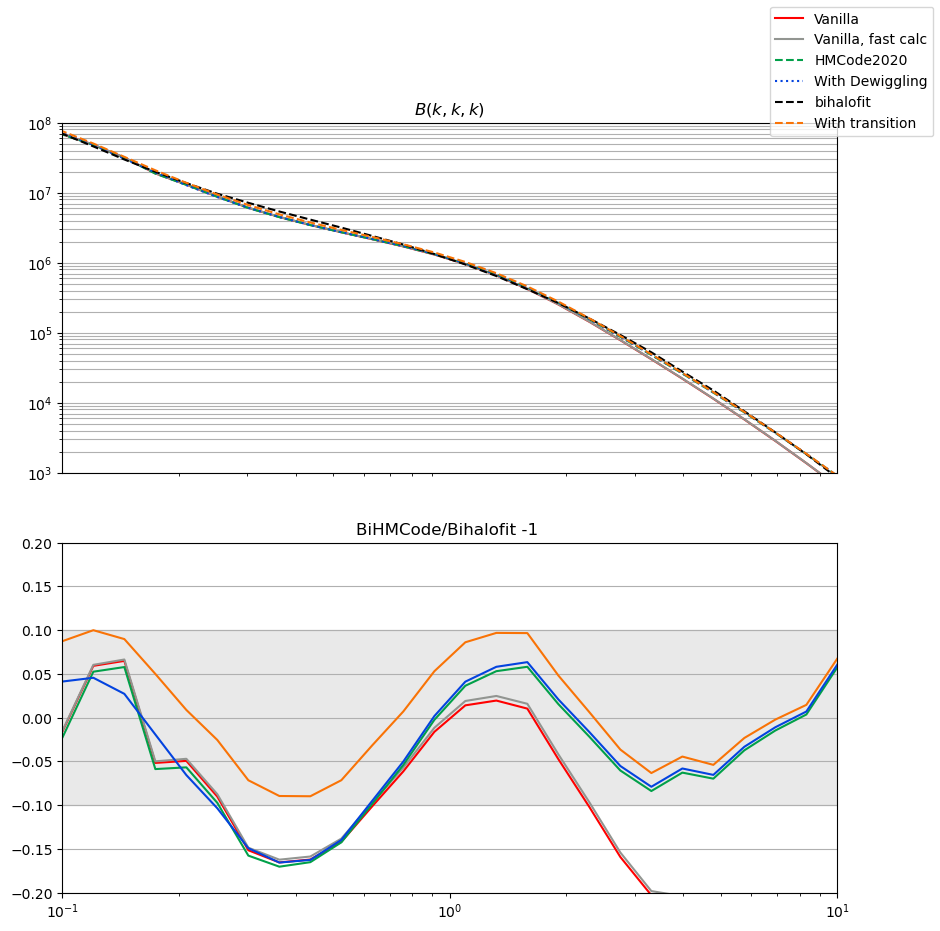

In [36]:
# Load bihalofit for comparison
dir="/home/laila/OneDrive/1_Work/5_Projects/05_BiHMCode/"
bihalofit=np.loadtxt(dir+"bihalofit/Bispectrum_from_Bihalofit.dat")

bihalofit_bispec=bihalofit[:,3]
bihalofit_k=bihalofit[:101,2]
bihalofit_bispec_res=bihalofit_bispec.reshape((101,101,101))

bihalofit_int=np.interp(ks, bihalofit_k, np.array([bihalofit_bispec_res[i,i,i] for i in range(len(bihalofit_k))]))

# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-0.2, 0.2)
axs[0].set_ylim(1e3,1e8)
axs[0].set_xlim(0.1, 10)
axs[1].set_xlim(0.1, 10)

axs[0].set_title(r"$B(k,k,k)$")
Halo1,=axs[0].plot(ks, np.array([BispecVanilla[i,i,i] for i in range(len(ks))]), label='Vanilla', ls='-', color='red')
# Halo2,=axs[0].plot(ks, np.array([Bi_1hVanilla[i,i,i] for i in range(len(ks))]), label='1-halo', ls='--', color='red')
# Halo3,=axs[0].plot(ks, np.array([Bi_2hVanilla[i,i,i] for i in range(len(ks))]), label='2-halo', ls=':', color='red')
# BiHMCode,=axs[0].plot(ks, np.array([Bi_3hVanilla[i,i,i] for i in range(len(ks))]), label='3-halo', ls='-.', color='red')

Halo1FC,=axs[0].plot(ks, np.array([BispecVanilla_fast[i,i,i] for i in range(len(ks))]), label='Vanilla, fast calc',ls='-', color='xkcd:grey')
# Halo2FC,=axs[0].plot(ks, np.array([Bi_1hVanilla_fast[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:grey')
# Halo3FC,=axs[0].plot(ks, np.array([Bi_2hVanilla_fast[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:grey')
# BiHMCodeFC,=axs[0].plot(ks, np.array([Bi_3hVanilla_fast[i,i,i] for i in range(len(ks))]),  ls='-.', color='xkcd:grey')

Halo1FCBloated,=axs[0].plot(ks, np.array([BispecHMCode2020[i,i,i] for i in range(len(ks))]), label='HMCode2020', ls='--', color='xkcd:emerald')
# Halo2FCBloated,=axs[0].plot(ks, np.array([Bi_1hHMCode2020[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:emerald')
# Halo3FCBloated,=axs[0].plot(ks, np.array([Bi_2hHMCode2020[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:emerald')
#BiHMCodeFCBloated,=axs[0].plot(ks, np.array([Bi_3hHMCode2020[i,i,i] for i in range(len(ks))]), color='xkcd:emerald', ls='--')


#Halo1FCdwg,=axs[0].plot(ks, np.array([Bi_3hHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), ls='-.', color='xkcd:blue')
#Halo2FCdwg,=axs[0].plot(ks, np.array([Bi_1hHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), ls='--', color='xkcd:blue')
#Halo3FCdwg,=axs[0].plot(ks, np.array([Bi_2hHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), ls=':', color='xkcd:blue')

BiHMCodeFCdwg,=axs[0].plot(ks, np.array([BispecHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]), label='With Dewiggling', color='xkcd:blue', ls=':')


Bihalofit,=axs[0].plot(ks, bihalofit_int, label='bihalofit', color='k', ls='--')

alpha1=0.9
alpha2=0.95
trans=np.array([np.power(np.power(np.power(Bi_1hHMCode2020_fast_dwg[i,i,i], alpha1) + np.power(Bi_2hHMCode2020_fast_dwg[i,i,i], alpha1), alpha2/alpha1) 
                         + np.power(Bi_3hHMCode2020_fast_dwg[i,i,i], alpha2), 1/alpha2) for i in range(len(ks))])
#trans=np.array([1.2*Bi_1hHMCode2020[i,i,i]+Bi_3hHMCode2020[i,i,i]+Bi_2hHMCode2020[i,i,i] for i in range(len(ks))])

axs[0].plot(ks, trans, color='xkcd:orange', ls='--', label='With transition')

axs[1].set_title(r"BiHMCode/Bihalofit -1 ")
Ratio,=axs[1].plot(ks, np.array([BispecVanilla[i,i,i] for i in range(len(ks))]/bihalofit_int-1), color='red')
RatioFC,=axs[1].plot(ks, np.array([BispecVanilla_fast[i,i,i] for i in range(len(ks))]/bihalofit_int-1), color='xkcd:grey')
RatioFC,=axs[1].plot(ks, np.array([BispecHMCode2020[i,i,i] for i in range(len(ks))]/bihalofit_int-1), color='xkcd:emerald')
RatioFC,=axs[1].plot(ks, np.array([BispecHMCode2020_fast_dwg[i,i,i] for i in range(len(ks))]/bihalofit_int-1), color='xkcd:blue')

RatioFC,=axs[1].plot(ks, trans/bihalofit_int-1, color='xkcd:orange')


axs[1].fill_between(ks, -np.ones_like(ks)*0.1, np.ones_like(ks)*0.1, color='xkcd:grey', alpha=0.2)


fig.legend()
